# Определение выгодного тарифа для телеком компании

**Краткое описание:**

В нашем распоряжении данные компании «Мегалайн» (федерального оператора сотовой связи) о 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам Мегалайна предлагают два тарифных плана: «Смарт» и «Ультра». 

**Цели проекта:**
- Рекомендации для коммерческого департамента по распределению рекламного бюджета в пользу какого-либо из двух тарифов.
- Предварительный анализ тарифов на небольшой выборке клиентов. 
- Анализ пользовательского поведения.
- Оценка коммерческой выгоды тарифов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# загрузим имеющиеся файлы с данными
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv') 
messages = pd.read_csv('/datasets/messages.csv') 
tariffs = pd.read_csv('/datasets/tariffs.csv') 
users = pd.read_csv('/datasets/users.csv')

In [3]:
users['reg_date_month'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d').dt.month
dff = users.pivot_table(index='reg_date_month', columns='tariff', values='user_id', aggfunc='count')
dff['ultra'].sum()

149

### Просмотр и обработка данных

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
calls.describe()

,duration,user_id
count,202607.000,202607.000
mean,6.756,1253.941
std,5.843,144.723
min,0.000,1000.000
25%,1.300,1126.000
50%,6.000,1260.000
75%,10.700,1379.000
max,38.000,1499.000


In [7]:
# переведем данные в столбце с датой в формат даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [8]:
# проверим количество звонков с нулевой продолжительностью
calls.query('duration == 0').shape[0]

39613

In [9]:
# проверим фиксируются ли короткие звонки и насколько коротка их продолжительность
calls.query('0.02 > duration > 0')

,id,call_date,duration,user_id
453,1001_85,2018-12-12,0.010,1001
1824,1005_421,2018-08-03,0.010,1005
5333,1015_53,2018-09-10,0.010,1015
10569,1027_439,2018-09-14,0.010,1027
10649,1027_519,2018-09-02,0.010,1027
...,...,...,...,...
198522,1487_109,2018-11-11,0.010,1487
198643,1488_105,2018-11-09,0.010,1488
199752,1492_63,2018-10-18,0.010,1492
199992,1492_303,2018-11-01,0.010,1492


1/5 данных с продолжительностью 0.0 мин. Можно выдвинуть несколько гипотез

Первая заключается в том, что данные звонки с небольшой продолжительностью окреглены в меньшую сторону до нулевых значений. Однако наличие в данных звонков с продолжительностью 0.01 мин дают усомниться в этой версии и принять в качестве рабочей следующую гипотезу.

РАБОЧАЯ ГИПОТЕЗА.  Предположим, что звонки с продолжительностью 0.0 мин - это исходящие вызовы, которые можно категоризировать как неотвеченные зконки на стороне адресата(абонент, которому был адресован звонок). Такое явление довольно частое и можно предположить, что оно соответсвует оценке 20% от общего количества звонков.

Поскольку такие звонки не иформативны и не влияют на дльнейшие расчеты, то логично будет очистить от них данные.

In [10]:
# сохраним в отдельный фрейм данные 
# с продолжительностью звонков больше 0.0 минут
calls_abovezero = calls.copy().query('duration > 0.0')

Согласно условиям договора, количество неполных минут и мегабайт округляется вверх. Поэтому для дальнейших расчетов финансовых показателей нам потребуется информация с полными минутами/мегабайтами:

In [11]:
# создадим новый стоблец с округленными значениями минут
# предварительно импортируем библиотеку для округления столбца вверх целиком
calls_abovezero['duration_rounded'] = np.ceil(calls_abovezero['duration']).astype('int')

In [12]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,1052.810,2018-09-07,1000
2,2,1000_2,1197.260,2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


In [13]:
# удалим ненужный столбец, дублирующий индексы
del internet['Unnamed: 0']

In [14]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [15]:
internet.describe()

,mb_used,user_id
count,149396.000,149396.000
mean,370.192,1252.100
std,278.301,144.051
min,0.000,1000.000
25%,138.188,1130.000
50%,348.015,1251.000
75%,559.553,1380.000
max,1724.830,1499.000


In [16]:
# проверим фиксируется ли небольшой траффик с сецлью понимания природы возникновения нулевых значений
# не являются ли нули итогом округления небольшого траффика
internet.query('mb_used > 0').sort_values(by='mb_used').head(10)

,id,mb_used,session_date,user_id
15944,1055_402,0.030,2018-06-15,1055
85722,1291_278,0.040,2018-08-10,1291
108198,1370_3,0.060,2018-07-18,1370
11027,1038_76,0.070,2018-12-30,1038
11399,1040_22,0.070,2018-11-23,1040
12506,1044_143,0.080,2018-11-18,1044
124847,1421_32,0.080,2018-11-15,1421
19101,1065_246,0.080,2018-03-17,1065
27569,1096_77,0.090,2018-07-09,1096
102165,1341_280,0.090,2018-08-29,1341


In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [19]:
messages.describe()

,user_id
count,123036.000
mean,1256.989
std,143.524
min,1000.000
25%,1134.000
50%,1271.000
75%,1381.000
max,1499.000


In [20]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id           500 non-null int64
age               500 non-null int64
churn_date        38 non-null object
city              500 non-null object
first_name        500 non-null object
last_name         500 non-null object
reg_date          500 non-null object
tariff            500 non-null object
reg_date_month    500 non-null int64
dtypes: int64(3), object(6)
memory usage: 35.3+ KB


In [23]:
users.describe()

,user_id,age,reg_date_month
count,500.000,500.000,500.000
mean,1249.500,46.588,6.482
std,144.482,16.668,3.394
min,1000.000,18.000,1.000
25%,1124.750,32.000,4.000
50%,1249.500,46.000,7.000
75%,1374.250,62.000,9.000
max,1499.000,75.000,12.000


In [24]:
users.duplicated().sum()

0

### Вывод

На этапе просмотра предобработки данных было замечено несколько неточностей в плане формата и содержания данных.
Смысловые неточности были связаны с наличием нулевых значений в данных по продолжительности звонков и интернет-траффику.

Если с интернет-траффиком нулевые значения выглядят логично по причине отсутвтвия потребности/возможности пользователей, то в ситуации со звонкками мы приняли это явление за несостоявшиеся (неотвеченные, сброшенные) исходящие вызовы  наших абонентов.

Также, на этапе предобработки данные, содержащие даты, были приведены к соответствующим типам, округлены значения продолжительности звонков, удалены ненужные(ошибочные) данные. Можем приступать к дальнейшей работе с данными.

### Промежуточные рассчеты предоставления услуг в рассчете на 1 пользователя

In [25]:
# посчитаем продолжительность звонков на 1 пользователя
calls_user_stat = calls_abovezero.\
assign(month = lambda x: x['call_date'].dt.month).\
groupby(['user_id','month']).agg({'duration_rounded' : 'sum'}).reset_index()

calls_user_stat.head()

,user_id,month,duration_rounded
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


In [26]:
# посчитаем количество сообщений на 1 пользователя
messages_user_stat = messages.\
assign(month = lambda x: x['message_date'].dt.month).\
groupby(['user_id','month']).agg({'id' : 'count'}).reset_index()

messages_user_stat.columns=['user_id', 'month', 'messages_count']
messages_user_stat.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [27]:
# посчитаем интернет-траффик на 1 пользователя
internet_user_stat = internet.\
assign(month = lambda x: x['session_date'].dt.month).\
groupby(['user_id','month']).agg({'mb_used' : 'sum'}).reset_index()

internet_user_stat['mb_used'] = np.ceil(internet_user_stat['mb_used'])

internet_user_stat.head()


,user_id,month,mb_used
0,1000,5,2254.000
1,1000,6,23234.000
2,1000,7,14004.000
3,1000,8,14056.000
4,1000,9,14569.000


In [28]:
# создадим функцию для заполнения пустых значений
def fillna_and_convert_to_int(users_stat,columns):
    users_stat = users_stat.copy()
    for col in columns:
        users_stat[col] = users_stat[col].fillna(0).astype(int)
    return users_stat

# создадим функцию для категоризации Москвы и остальных регионов
def region_category(users_stat):
    if users_stat['city'] == 'Москва':
        return 'Москва'
    return 'Регионы'

In [29]:
# сведем ранее расчитанные данные в единую таблицу для дальнейшего анализа
users_stat = users[['user_id', 'tariff', 'city']].\
merge(calls_user_stat, how = 'left', on = 'user_id').\
merge(messages_user_stat, how = 'left', on = ['user_id', 'month']).\
merge(internet_user_stat, how = 'left', on = ['user_id', 'month']).\
pipe(fillna_and_convert_to_int, ['month', 'duration_rounded', 'messages_count', 'mb_used']).\
assign(region_group = lambda x: x.apply(region_category, axis=1))

users_stat

,user_id,tariff,city,month,duration_rounded,messages_count,mb_used,region_group
0,1000,ultra,Краснодар,5,159,22,2254,Регионы
1,1000,ultra,Краснодар,6,172,60,23234,Регионы
2,1000,ultra,Краснодар,7,340,75,14004,Регионы
3,1000,ultra,Краснодар,8,408,81,14056,Регионы
4,1000,ultra,Краснодар,9,466,57,14569,Регионы
...,...,...,...,...,...,...,...,...
3171,1498,smart,Владикавказ,10,247,42,20580,Регионы
3172,1499,smart,Пермь,9,70,11,1846,Регионы
3173,1499,smart,Пермь,10,449,48,17789,Регионы
3174,1499,smart,Пермь,11,612,59,17964,Регионы


In [30]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [31]:
# создадим копию фрейма с тарифами, и присвоим в качестве индекса название тарифа
tariff_df = pd.read_csv('/datasets/tariffs.csv',index_col = 'tariff_name')

# создадим набор функций для расчета коммерческих показателей каждого пользователя
# создадим функцию для расчета выручки от каждого клиента за звонки:
def get_overpayment_call(df, tariff_df = tariff_df):
    tariff = df['tariff']
    min_inc = tariff_df.loc[tariff, 'minutes_included']
    call_overlimit = max(df['duration_rounded'] - min_inc, 0)
    call_overpay = call_overlimit * tariff_df.loc[tariff, 'rub_per_minute']
    return call_overpay

# напишем аналогичную функцию для расчета выручки от каждого клиента за сообщения:
def get_overpayment_mes(row, tariff_df = tariff_df):
    tariff = row['tariff']
    mes_inc = tariff_df.loc[tariff, 'minutes_included']
    mes_overlimit = max(row['messages_count'] - tariff_df.loc[tariff, 'messages_included'], 0)
    mes_overpay = mes_overlimit * tariff_df.loc[tariff, 'rub_per_message']
    return mes_overpay

# функция для определения помесячной выручки на 1-го абонента за интернет 
def get_overpayment_int(row, tariff_df = tariff_df):
    tariff = row['tariff']
    mb_inc = tariff_df.loc[tariff, 'mb_per_month_included']
    mb_overlimit = max(row['mb_used'] - tariff_df.loc[tariff, 'mb_per_month_included'], 0)
    int_overpay = np.ceil(mb_overlimit/1000) * tariff_df.loc[tariff, 'rub_per_gb']
    return int_overpay

# функция для расчета общей суммы переплаты и выручки на одного абонента в месяц
def get_total_overpay_income(row, tariff_df = tariff_df):
    tariff = row['tariff']
    total_over = row['calls_overpay'] + row['messages_overpay'] + row['internet_overpay']
    total_inc = total_over + tariff_df.loc[tariff, 'rub_monthly_fee']
    return total_over, total_inc

In [32]:
#расчитаем для каждого абонента и месяца переплату за каждый вид услуг
users_stat['calls_overpay'] = users_stat[['tariff', 'duration_rounded']].apply(get_overpayment_call, axis = 1)
users_stat['messages_overpay'] = users_stat[['tariff', 'messages_count']].apply(get_overpayment_mes, axis = 1)
users_stat['internet_overpay'] = users_stat[['tariff', 'mb_used']].apply(get_overpayment_int, axis = 1)

# посчитаем суммарную переплату и вырчку на абонента в месяц
users_stat[['total_overpay', 'total_income']] = (
    users_stat[['tariff', 'calls_overpay', 'messages_overpay', 'internet_overpay']]
    .apply(get_total_overpay_income, axis=1, result_type="expand")
)
users_stat

,user_id,tariff,city,month,duration_rounded,messages_count,mb_used,region_group,calls_overpay,messages_overpay,internet_overpay,total_overpay,total_income
0,1000,ultra,Краснодар,5,159,22,2254,Регионы,0,0,0.000,0.000,1950.000
1,1000,ultra,Краснодар,6,172,60,23234,Регионы,0,0,0.000,0.000,1950.000
2,1000,ultra,Краснодар,7,340,75,14004,Регионы,0,0,0.000,0.000,1950.000
3,1000,ultra,Краснодар,8,408,81,14056,Регионы,0,0,0.000,0.000,1950.000
4,1000,ultra,Краснодар,9,466,57,14569,Регионы,0,0,0.000,0.000,1950.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,1498,smart,Владикавказ,10,247,42,20580,Регионы,0,0,1200.000,1200.000,1750.000
3172,1499,smart,Пермь,9,70,11,1846,Регионы,0,0,0.000,0.000,550.000
3173,1499,smart,Пермь,10,449,48,17789,Регионы,0,0,600.000,600.000,1150.000
3174,1499,smart,Пермь,11,612,59,17964,Регионы,336,27,600.000,963.000,1513.000


In [33]:
# для удобства сохраним срезы по двум разным тарифам в отдельные переменные
users_stat_ultra = users_stat.copy().query("tariff == 'ultra'")
users_stat_smart = users_stat.copy().query("tariff == 'smart'")

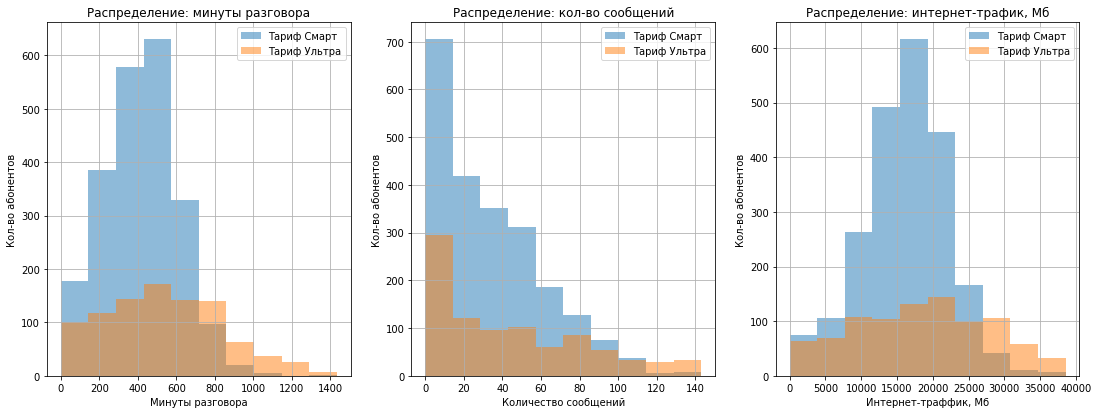

In [48]:
# создадим словарь для построения графиков:
dict_for_hist = {'duration_rounded' : [35, 'Минуты разговора', 'Распределение: минуты разговора'],
                 'messages_count' : [20, 'Количество сообщений', 'Распределение: кол-во сообщений'],
                 'mb_used' : [25,'Интернет-траффик, Мб', 'Распределение: интернет-трафик, Мб']}

# задаем параметры сетки и размер графиков
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18.5, 6.5)

num_of_subplot = 0

# автоматизируем построение гистограмм с использованием цикла
for key in dict_for_hist.keys():
    _, bins, *_ = ax[num_of_subplot].hist(users_stat_smart[key], label='Тариф Смарт', alpha=0.5)
    ax[num_of_subplot].hist(users_stat_ultra[key], label='Тариф Ультра', alpha=0.5, bins=bins)
    
    ax[num_of_subplot].set_xlabel(dict_for_hist[key][1])
    ax[num_of_subplot].set_ylabel('Кол-во абонентов')
    
    ax[num_of_subplot].set_title(dict_for_hist[key][2])
        
    ax[num_of_subplot].legend()
    ax[num_of_subplot].grid()
    
    num_of_subplot += 1

### Вывод

Гистограммы наглядно демострируют нам превосходство количество абонентов, использующих, тариф "Cмарт". 

Но, даже в таком виде мы можем определить, что в случае со звонками и интернет-траффиком наблюдается распределение Пуассона с положительной скошенностью.

В случае с использованием смс-сообщений мы наблюдаем распределение схожее к геометрическому. Это можно объяснить низкой популярностью смс-сообщений и замещением их множеством интернет-месседжеров. Поэтому большое количество абонентов, не использующих смс/использующих их в небольших количествах, выглядит вполне логичным и закомерным.

Тариф СМАРТ.
Абонентам тарифа Смарт требуется в среднем 420 минут в месяц, 15-18 Гб интернет-траффика, при этом 50% абонентов используют не более 30 сообщений в месяц.

Тариф УЛЬТРА.
На тарифе Ультра абоненты используют в среднем 545 минут разговора в месяц, при траффике около 16-22 Гб, 50% абонентов  отправляют не более 40 смс.

Как видим, при занчительно больших лимитах включенных в тариф Ультра, средние значения использования услуг в количественном выражении отличаются не пропорционально лимитам и стоимости тарифа Смарт. 

Так, при стоимости тарифа Ультра в 4 раза выше тарифа Смарт, разница использования минут разговора составлют всего около 20%, смс - 35%, интернета - 20%.

Однако этой информации нам недостаточно для определения коммерческой привлекательности того или иного тарифа. Продолжим анализ тарифов.

### Проверка гипотез

In [35]:
print('Тариф "Смарт"')
users_stat_smart[['duration_rounded', 'messages_count', 'mb_used', 'total_income']].describe()

Тариф "Смарт"


,duration_rounded,messages_count,mb_used,total_income
count,2223.000,2223.000,2223.000,2223.000
mean,419.063,33.362,16196.560,1303.667
std,189.326,28.275,5893.785,834.222
min,0.000,0.000,0.000,550.000
25%,285.000,10.000,12635.000,550.000
50%,423.000,28.000,16477.000,1040.000
75%,545.500,51.000,20045.000,1764.000
max,1435.000,143.000,38553.000,6970.000


In [36]:
print('Тариф "Ультра"')
users_stat_ultra[['duration_rounded', 'messages_count', 'mb_used', 'total_income']].describe()

Тариф "Ультра"


,duration_rounded,messages_count,mb_used,total_income
count,953.000,953.000,953.000,953.000
mean,544.306,48.452,19349.492,2073.085
std,307.619,46.615,10212.875,387.776
min,0.000,0.000,0.000,1950.000
25%,310.000,5.000,11413.000,1950.000
50%,526.000,38.000,19281.000,1950.000
75%,756.000,78.000,26831.000,1950.000
max,1673.000,224.000,49746.000,4950.000


In [37]:
#присвоим в переменную функцию lambda для расчета стандарного отклонения и дисперсии
#присовим ей соответствующие названия для корректного отображения в таблице
std_lambda = lambda x: x.std(ddof=1)
std_lambda.__name__ = 'std'
var_lambda = lambda x: x.var(ddof=1)
var_lambda.__name__ = 'var'

#сведем показатели среднего, дисперсии и стандартного отклонения в единую таблицу
user_month_statistics = users_stat.pivot_table(columns='tariff', 
                                               values=['duration_rounded', 'messages_count', 'mb_used', 'total_income'], 
                                               aggfunc=['mean', std_lambda, var_lambda])
user_month_statistics

mean                std                    var  \
tariff               smart     ultra    smart     ultra        smart   
duration_rounded   419.063   544.306  189.326   307.619    35844.190   
mb_used          16196.560 19349.492 5893.785 10212.875 34736703.057   
messages_count      33.362    48.452   28.275    46.615      799.489   
total_income      1303.667  2073.085  834.222   387.776   695926.441   

                                
tariff                   ultra  
duration_rounded     94629.236  
mb_used          104302820.326  
messages_count        2172.929  
total_income        150369.885

In [38]:
# h0 - средняя выручка пользователей Ультра и Смарт не различается
# h1 - средняя выручка пользователей Ультра и Смарт различается

#критичсекий уровень значимости
alpha = .05

result = st.ttest_ind(users_stat_ultra['total_income'], users_stat_smart['total_income'], equal_var = False)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.2480081428343975e-232
Отвергаем нулевую гипотезу


### Вывод

Полученное значение pvalue стремится к нулю, что говорит нам о том, что вероятность получить такое различие двух генеральных совокупностей случайно практически невозможно. Различия средних двух генеральных совокупностей статистически значими.

При таких раскладах получаем  практичски 100%-ю вероятность, что такое различие средних двух ген.совокупностей не случайно. Т.к. дисперсии двух выборок отличаются, параметр equal_var указали как False.

На основании расчетов выше видим, что средняя выручка абонентов Ультра выше выручки пользователей Смарт почти на 60% (2073 руб/мес против 1304 руб/мес).

In [39]:
# создадим две совокупности из имеющийся выборки на основании локации пользователей

# пользователи из Москвы
user_stat_moscow = users_stat.query("city == 'Москва'")

# пользователи других регионов
user_stat_regions = users_stat.query("city != 'Москва'")

In [40]:
# выведем таблицу в разрезе групп регионов со статистическими показателями для предварительной оценки ситуации
region_statistics = users_stat.pivot_table(columns='region_group', 
                                               values=['total_income'], 
                                               aggfunc=['mean', std_lambda, var_lambda])

region_statistics

mean              std                var           
region_group   Москва  Регионы  Москва Регионы     Москва    Регионы
total_income 1554.085 1529.894 756.536 822.572 572347.231 676625.156

In [41]:
# Проверим гипотезу
# h0 - средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов
# h1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#критичсекий уровень значимости
alpha = .05

result = st.ttest_ind(user_stat_moscow['total_income'], user_stat_regions['total_income'], equal_var = True)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.5075403670805176
Не получилось отвергнуть нулевую гипотезу


### Вывод

Полученные данные говорят о том, что c вероятностью 50% отсутствие различий средней выручки пользователей Москвы и других регионов   не случайны. Средние значения выборок расчитанные на предыдущем шаге (см. сводная таблица по регионам )также указывают на минимальные отличия с небольшим перевесом средней выручки в пользу московских пользователей.

Таким образом, мы НЕ можем отвергнуть нулевую гипотезу, суть которой в том, что данные средней выручки в Москве и регионах не различаются. У нас есть основания полагать, что средние значения двух генеральных совокупностей с большой долей вероятности не различаются статистически значимо.

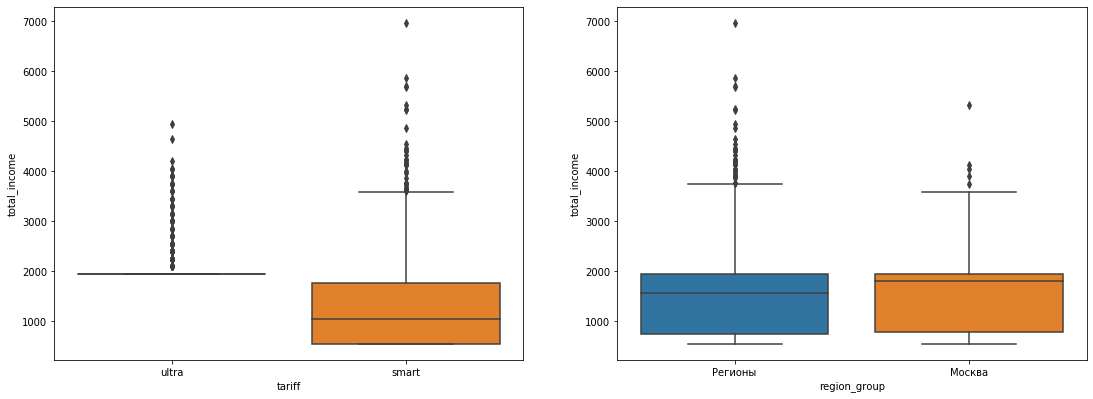

In [42]:
# для наглядности построим диаграмму распределения для группировки по регионам
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 6.5)
sns.boxplot(x='tariff', y='total_income', data=users_stat, ax=ax[0])
sns.boxplot(x='region_group', y='total_income', data=users_stat, ax=ax[1])
fig.show()

## Вывод

Расчеты средних значений выборок по тарифам Ультра и Смарт показали существенные различия средней выручки на 1 пользователя:
- больше 2000 руб/мес у пользователей тарифа Ультра против 1300 у пользователей тарифа Смарт. 

Эти показатели подкреплены и проверкой гипотезы о равенстве среднего двух генеральных совокупностей - с вероятностью близкой к 100% различия средних значений выручки двух генеральных совокупностей НЕ случайны.

На мой взгляд распределение рекламного бюджета Мегалайн логично распределить в пользу тарифа Ультра, т.к. пользователи этого тарифа приносят в среднем на 60% больше выручки. Отметим также, что даже показатели минимальной выручки превышают среднюю и медианную выручку пользователей Смарт, принося стабильно около от 1950 руб в месяц на каждого пользователя и больше.

Отметим также,что на данном этапе рассматривать распределение рекламного бюджета в разрезе регионов (Москва и остальные регионы) нецелесообразно, т.к. различия в коммерческих показателях двух совокупностей минимальна.

Нельзя и не учитывать тот факт, что при занчительно больших лимитах включенных в тариф Ультра, средние значения использования услуг в количественном выражении НЕ пропорциональны лимитам и стоимости тарифа Смарт. Так, при стоимости тарифа Ультра в 4 раза выше тарифа Смарт, разница использования минут разговора составлют всего около 20%, смс - 35%, интернета - 20%. 

Это еще один немаловажный довод в пользу показателей эффективности тарифа Ультра - большая выручка при относительно меньших издержках.

Резюмируя все изложенные реплики, мы можем рекомендовать тариф Ультра, как приоритетный вектор развития с бОльшим рекламным бюджетом. При этом Тариф Смарт также нуждается в рекламном бюджете, направленном на поддержание положительной динамики притока пользоваталей низкого и среднего ценовых сегментов.